# Multi-task Deep Learning Experiment using fastai Pytorch

This notebook is a line-by-line example of a multi-task deep learning model, implemented using the *fastai* v1 library for PyTorch. This model takes in an image of a human face and predicts their gender, race, and age. 

This notebook wants to show:
1. an example of a multi-task deep learning model;
2. the multi-task model makes better predictions than the individual model; and
2. how to use the fastai library to easily implement the model.

This document is written in a working Jupyter notebook, so you can run and change the code if you like (at least it's fun to randomly sample faces - some of them are famous).

## Multi-task learning

First, some quick introduction to multi-task learning.

### What it is 

> [wikipedia](https://en.wikipedia.org/wiki/Multi-task_learning): Multi-task learning (MTL) is a subfield of machine learning in which *multiple learning tasks are solved at the same time*, while exploiting commonalities and differences across tasks. 

    In this notebook, *multiple learning tasks* are the three tasks to predict gender, race (both classification tasks), and age (a regression task), respectively.

### Why do it
> [wikipedia](https://en.wikipedia.org/wiki/Multi-task_learning): This can result in *improved learning efficiency and prediction accuracy* for the task-specific models, when compared to training the models separately.

    In this notebook,
    - Regarding *improved learning efficiency*: we run the multi-task model once instead of three time for the single-task models (all four models have similar run time). 
    - Regarding *improved prediction accuracy*: we will show that the multi-task model cut average age prediction error in half from 10 years to 5 years while holding the gender and race prediction accuracy almost the same. 

### Why it works  
> [wikipedia](https://en.wikipedia.org/wiki/Multi-task_learning): Multi-task learning works because *regularization induced by requiring an algorithm to perform well on a related task* can be superior to regularization that prevents overfitting by penalizing all complexity uniformly. 
    
    We will not cover the math here. Wikipedia provides some good resources. 

## fastai

We use the library [fastai v1 for PyTorch](https://www.fast.ai/2018/10/02/fastai-ai/) to implement our model. This software is built by the organization also called [fastai](https://www.fast.ai/) and founded by Jeremy Howard and Rachel Thomas to "make neural nets uncool again". Its free on-line deep learning courses are considered by many researchers the best out there. The fastai software library "simplifies training fast and accurate neural nets using modern best practices", in other words, it's really easy to use and it works really well.

##  The data and the problem

We use [UTKFace](http://aicip.eecs.utk.edu/wiki/UTKFace) data for this experiment.
> UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc. 

We will try to predict gender, race (both classification tasks), and age (a regression task), respectively, based on the image. In the setting of multi-task learning, we could think of age as the central task partly because it is more difficult. 

Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pathlib import Path

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from fastai import *
from fastai.vision import *

We can see fastai v1 is being used:

In [2]:
import fastai; fastai.__version__

'1.0.59'

`pathlib` is a good package to deal with file paths.

In [3]:
Path

pathlib.Path

Create these `Path` objects so that 
- `pdata`: path to dataset
- `p`: path to project folder

In [4]:
pdata = Path('F:\\Multi-task Deep Learning Experiment using fastai Pytorch\\data\\UTKFace\\')
p = Path('.')
pdata

WindowsPath('F:/Multi-task Deep Learning Experiment using fastai Pytorch/data/UTKFace')

We will use the 23k cropped faces.

In [5]:
fns = list(pdata.glob('*.jpg'))
len(fns)

23708

The labels of each face image is embedded in the file name, formatted like `[age]_[gender]_[race]_[date&time].jpg`

`[age]` is an integer from 0 to 116, indicating the age
`[gender]` is either 0 (male) or 1 (female)
`[race]` is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
`[date&time]` is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [6]:
fns[:3]

[WindowsPath('F:/Multi-task Deep Learning Experiment using fastai Pytorch/data/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg'),
 WindowsPath('F:/Multi-task Deep Learning Experiment using fastai Pytorch/data/UTKFace/100_0_0_20170112215240346.jpg.chip.jpg'),
 WindowsPath('F:/Multi-task Deep Learning Experiment using fastai Pytorch/data/UTKFace/100_1_0_20170110183726390.jpg.chip.jpg')]

Remove files with bad-format names (only a few).

In [7]:
fns = [fn for fn in fns if len(str(fn).split('/')[-1].split('_'))==4 and '__' not in str(fn)]
len(fns)

23705

A handy function to look at the content of a dictionary. 

In [8]:
def show_dct(dct, n=3):
    return dict(list(dct.items())[:n])

Create these look-up maps
- `i2fn`: image index to filename
- `fn2i`: filename to index

In [9]:
i2fn = fns
fn2i = {fn:i for i,fn in enumerate(i2fn)}
show_dct(fn2i)

{WindowsPath('F:/Multi-task Deep Learning Experiment using fastai Pytorch/data/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg'): 0,
 WindowsPath('F:/Multi-task Deep Learning Experiment using fastai Pytorch/data/UTKFace/100_0_0_20170112215240346.jpg.chip.jpg'): 1,
 WindowsPath('F:/Multi-task Deep Learning Experiment using fastai Pytorch/data/UTKFace/100_1_0_20170110183726390.jpg.chip.jpg'): 2}

The labels of each face image is embedded in the file name, formated like `[age]_[gender]_[race]_[date&time].jpg`

In [10]:
bs_fns = [os.path.basename(o) for o in fns]
bs_fns[:3]

['100_0_0_20170112213500903.jpg.chip.jpg',
 '100_0_0_20170112215240346.jpg.chip.jpg',
 '100_1_0_20170110183726390.jpg.chip.jpg']

Create these look-up maps

- `i2age`: image index to age
- `i2gender`: image index to gender
- `i2race`: image index to race

In [11]:
i2age, i2gender, i2race = zip(*[bs_fn.split('_')[:3] for bs_fn in bs_fns])

`[age]` is an integer from 0 to 116, indicating the age

In [12]:
i2age = [int(o) for o in i2age]
i2age[:3]

[100, 100, 100]

`[gender]` is either 0 (male) or 1 (female)

In [13]:
o2gender = {'0': 'm', '1': 'f'}
i2gender = [o2gender[o] for o in i2gender]

i2gender[:3]

['m', 'm', 'f']

`[race]` is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

In [14]:
o2race = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
i2race = [o2race[int(o)] for o in i2race]
i2race[:3]

['White', 'White', 'White']

## Explore data

Some sanity check on the data.

Gender counts. Seems even.

In [15]:
Counter(i2gender)

Counter({'m': 12391, 'f': 11314})

Race counts. Notice this might not be the same race distribution as the data in your own problem. 

In [16]:
Counter(i2race).most_common()

[('White', 10078),
 ('Black', 4526),
 ('Indian', 3975),
 ('Asian', 3434),
 ('Others', 1692)]

Gender per race counts. Seems relatively even.

In [17]:
sorted(Counter(list(zip(i2race, i2gender))). items())

[(('Asian', 'f'), 1859),
 (('Asian', 'm'), 1575),
 (('Black', 'f'), 2208),
 (('Black', 'm'), 2318),
 (('Indian', 'f'), 1714),
 (('Indian', 'm'), 2261),
 (('Others', 'f'), 932),
 (('Others', 'm'), 760),
 (('White', 'f'), 4601),
 (('White', 'm'), 5477)]

Let's look at the distribution of age. Looks like babies and 20-year olds like their pictures taken the most.

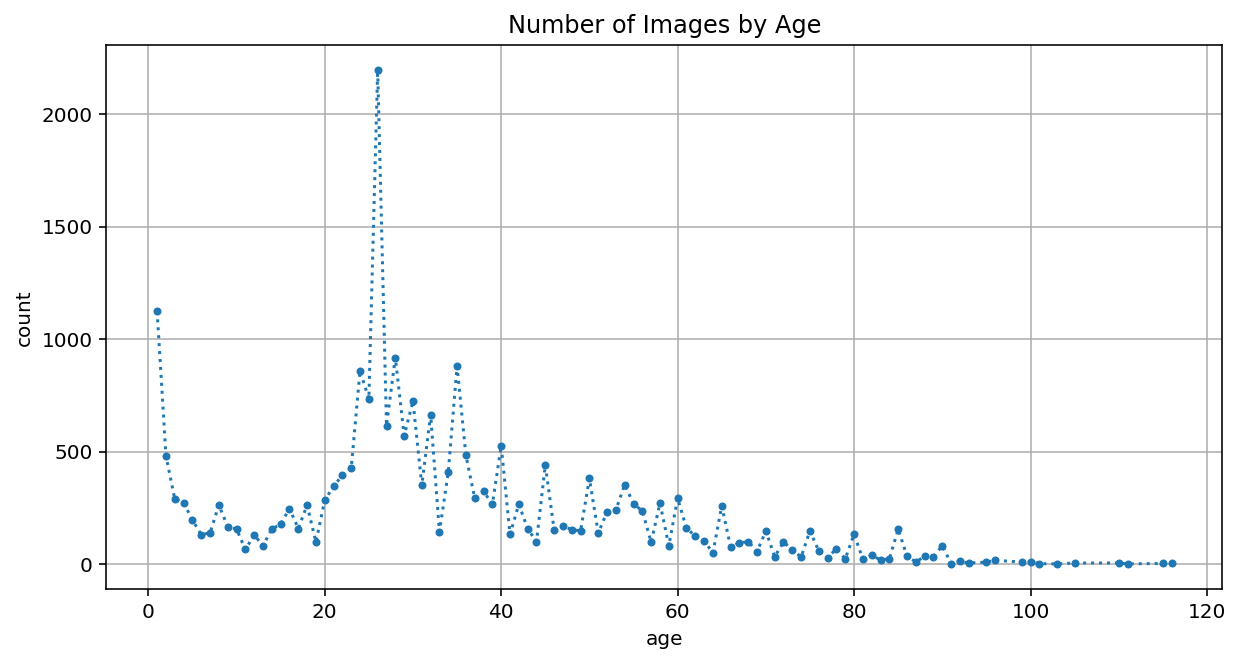

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(*zip(*sorted(Counter(i2age).items())), '.:')
plt.title('Number of Images by Age')
plt.ylabel('count')
plt.xlabel('age')
plt.grid()

Distribution of age per gender. Nothing strange.

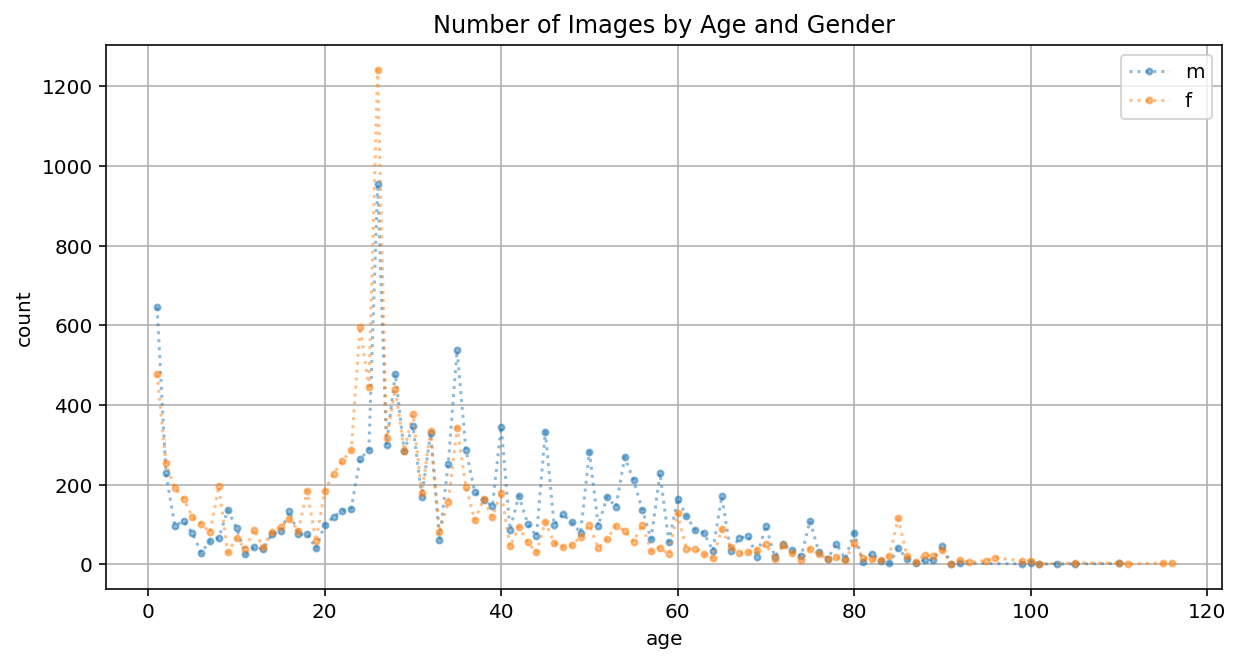

In [19]:
plt.figure(figsize=(10, 5))
for gender in o2gender.values():
    ages_gender=[age for i, age in enumerate(i2age) if i2gender[i]==gender]
    plt.plot(*zip(*sorted(Counter(ages_gender).items())), '.:', label=gender, alpha=.5)
    plt.title('Number of Images by Age and Gender')
    plt.ylabel('count')
    plt.xlabel('age')
    plt.legend()
plt.grid()

Distribution of age per race. Nothing strange.

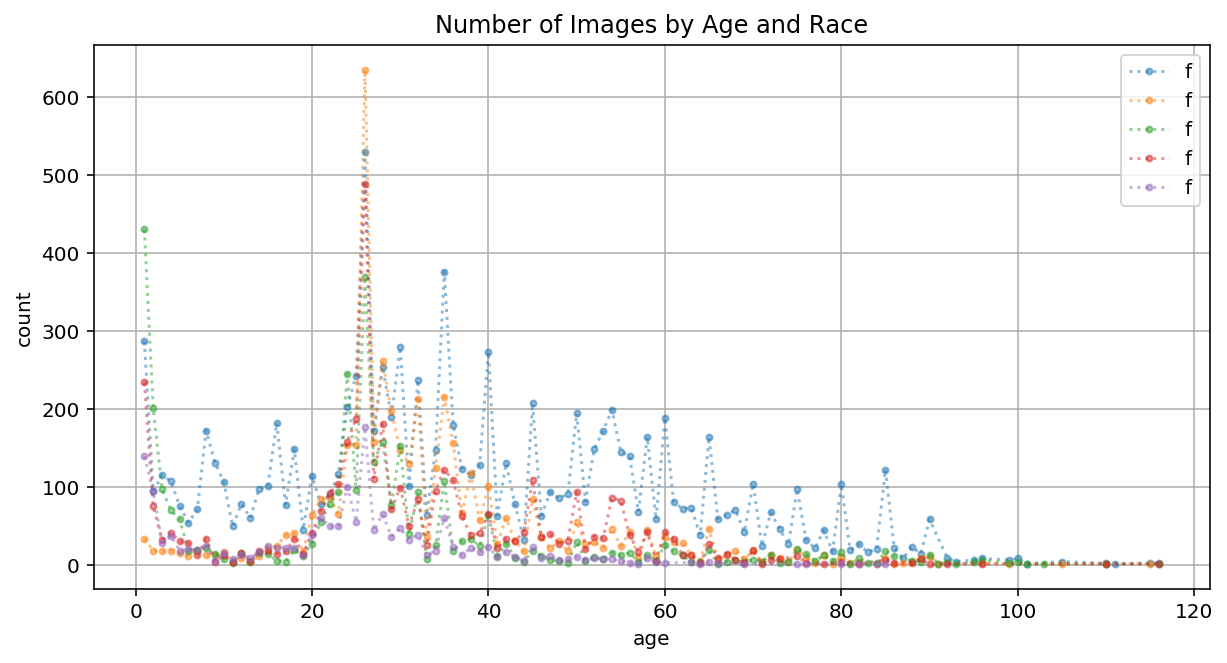

In [20]:
plt.figure(figsize=(10, 5))

for race in o2race.values():
    ages_race=[age for i, age in enumerate(i2age) if i2race[i]==race]
    plt.plot(*zip(*sorted(Counter(ages_race).items())), '.:', label=gender, alpha=.5)
    plt.title('Number of Images by Age and Race')
    plt.ylabel('count')
    plt.xlabel('age')
    plt.legend()
plt.grid()


Let's look at some pictures for sanity check.

Random picture. Notice that `open_image` is a fastai function that returns a fastai `Image` object.

age: 25; gender: m; race: Black


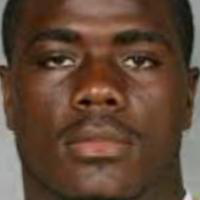

In [21]:
fn = np.random.choice(fns)
i = fn2i[fn]
print(f'age: {i2age[i]}; gender: {i2gender[i]}; race: {i2race[i]}')
open_image(fn)

A grid of random pictures. Using fastai `show_image` function it's easy to arrange the images by the `axs`.

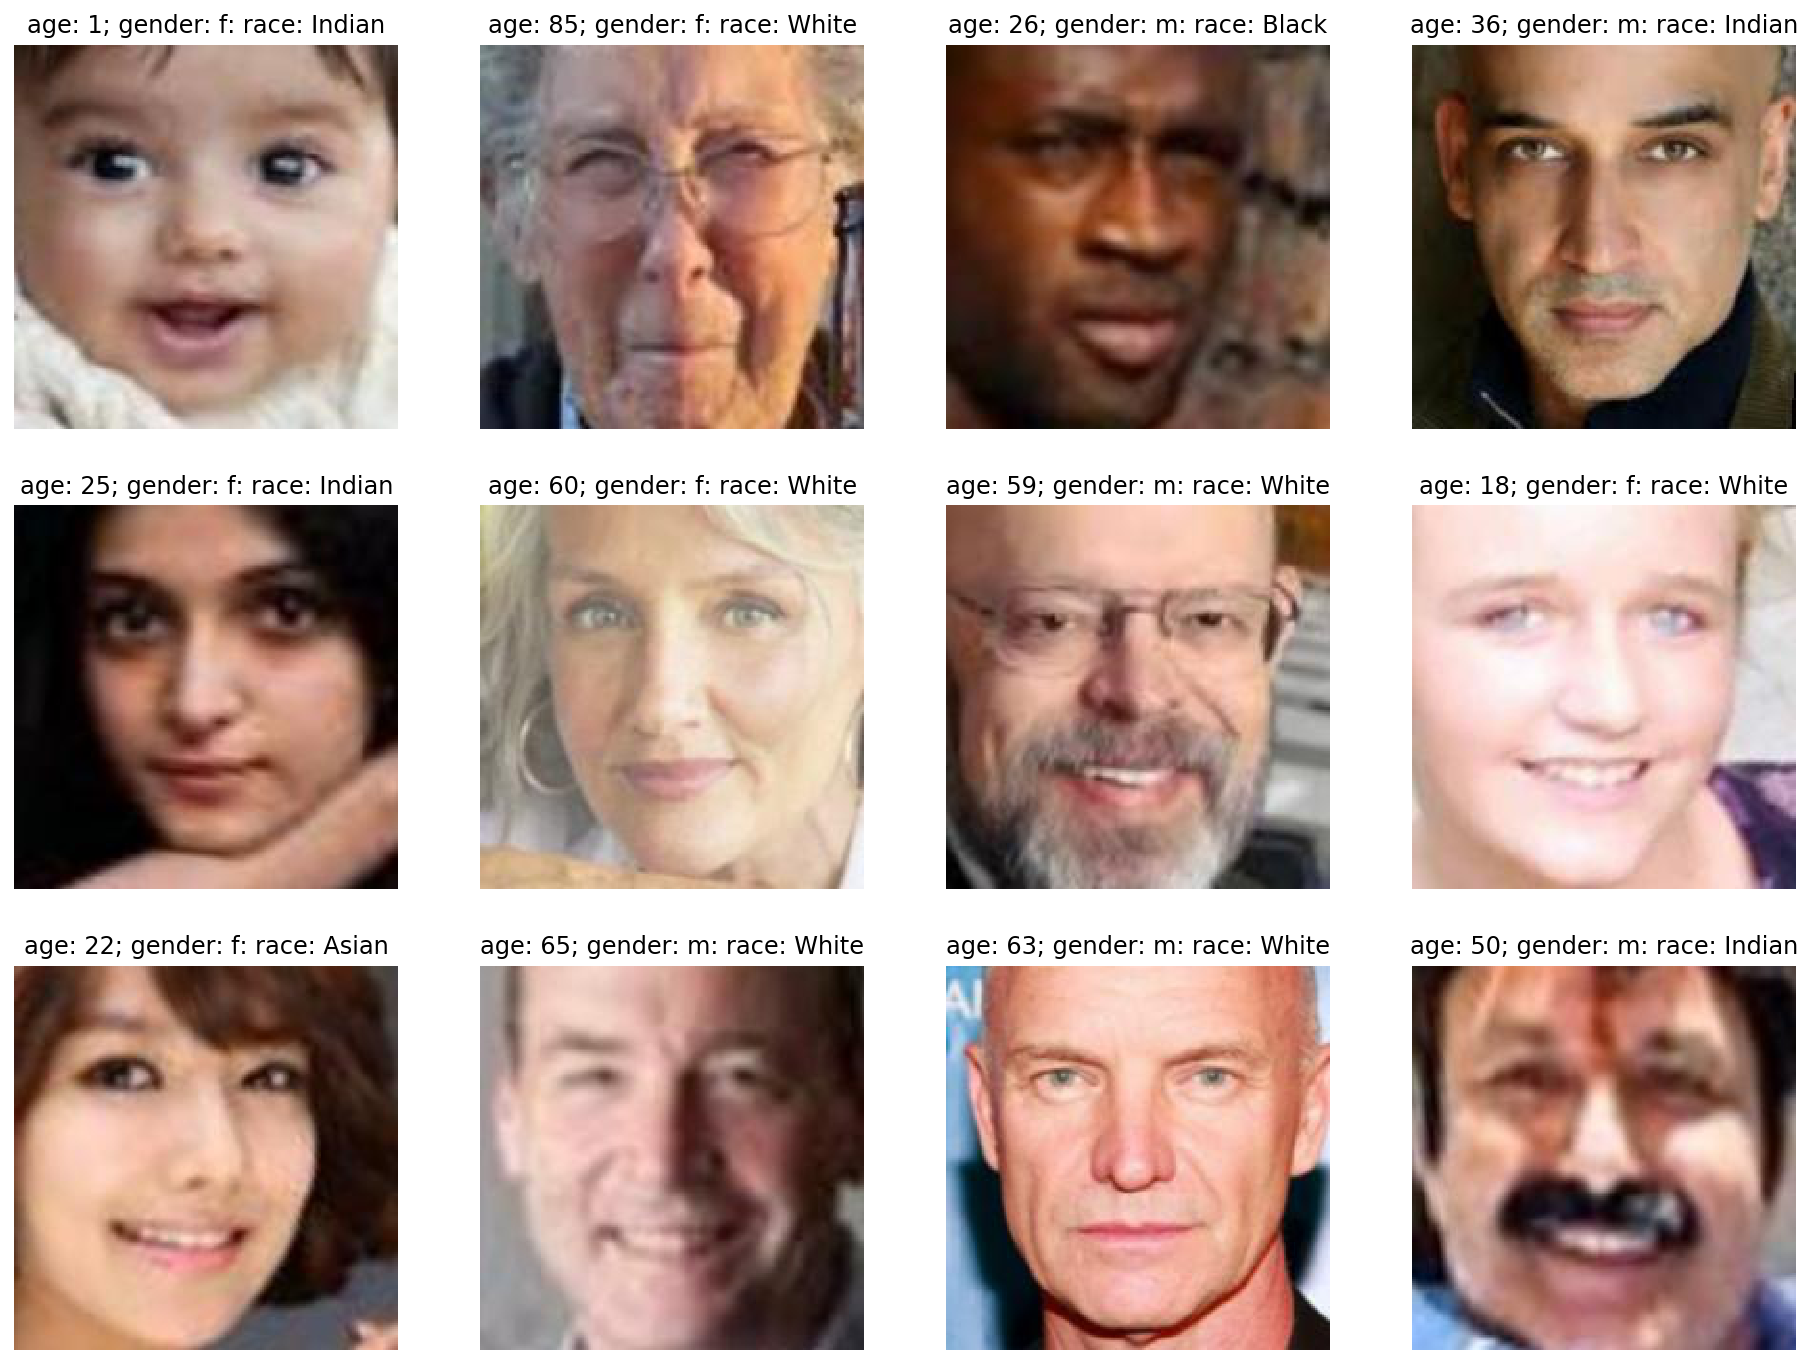

In [22]:
nr, nc = 3, 4
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(4*nc, 4*nr))
fns_sample = np.random.choice(fns, nr*nc)

for j, fn in enumerate(fns_sample):
    i = fn2i[fn]
    show_image(open_image(fn), axs[j//nc, j%nc])
    axs[j//nc, j%nc].set(title=f'age: {i2age[i]}; gender: {i2gender[i]}: race: {i2race[i]}')

## Process data for modeling

Combine the above maps into a pandas data frame.

In [23]:
df = pd.DataFrame({'img_name': bs_fns, 'age': i2age, 'gender': i2gender, 'race': i2race})
df2 = pd.DataFrame({'img_name': fns, 'age': i2age, 'gender': i2gender, 'race': i2race})

df.shape

(23705, 4)

In [24]:
df

,img_name,age,gender,race
0,100_0_0_20170112213500903.jpg.chip.jpg,100,m,White
1,100_0_0_20170112215240346.jpg.chip.jpg,100,m,White
2,100_1_0_20170110183726390.jpg.chip.jpg,100,f,White
3,100_1_0_20170112213001988.jpg.chip.jpg,100,f,White
4,100_1_0_20170112213303693.jpg.chip.jpg,100,f,White
...,...,...,...,...
23700,9_1_3_20161220222856346.jpg.chip.jpg,9,f,Indian
23701,9_1_3_20170104222949455.jpg.chip.jpg,9,f,Indian
23702,9_1_4_20170103200637399.jpg.chip.jpg,9,f,Others
23703,9_1_4_20170103200814791.jpg.chip.jpg,9,f,Others


Random sampling 80% training and 20% validation. Note that we only do this once so we use the same split for the three single-task and one multi-task models.

In [25]:
df['is_valid'] = np.random.choice(2, size=len(df), p=[0.8, 0.2])
df2['is_valid'] = df['is_valid']

In [26]:
df.head()

,img_name,age,gender,race,is_valid
0,100_0_0_20170112213500903.jpg.chip.jpg,100,m,White,0
1,100_0_0_20170112215240346.jpg.chip.jpg,100,m,White,0
2,100_1_0_20170110183726390.jpg.chip.jpg,100,f,White,0
3,100_1_0_20170112213001988.jpg.chip.jpg,100,f,White,1
4,100_1_0_20170112213303693.jpg.chip.jpg,100,f,White,0


In [27]:
df2.head()

,img_name,age,gender,race,is_valid
0,F:\Multi-task Deep Learning Experiment using f...,100,m,White,0
1,F:\Multi-task Deep Learning Experiment using f...,100,m,White,0
2,F:\Multi-task Deep Learning Experiment using f...,100,f,White,0
3,F:\Multi-task Deep Learning Experiment using f...,100,f,White,1
4,F:\Multi-task Deep Learning Experiment using f...,100,f,White,0


Save the data frame. 

In [28]:
df.to_csv('img2targets.csv', index=False)
df2.to_csv('img2targets2.csv', index=False)

Sanity check again by look at random pictures.

age: 46, gender: f, race: White


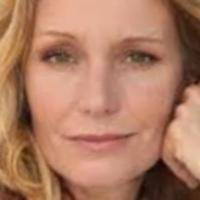

In [29]:
i = np.random.choice(len(df))
dfi = df.iloc[i]

print(f'age: {dfi["age"]}, gender: {dfi["gender"]}, race: {dfi["race"]}')
open_image(pdata/dfi["img_name"])

In [30]:
pdata/dfi["img_name"]

WindowsPath('F:/Multi-task Deep Learning Experiment using fastai Pytorch/data/UTKFace/46_1_0_20170104235700307.jpg.chip.jpg')

## Single-task models

For comparison, we will first build single-task models for the three tasks: gender, race, and age predictions. We will build the multi-task model in the next section.

### gender model

In [31]:
target = 'gender'

The code below creates two fastai `ImageClassificationDataset` objects, one for training and one for validation. The `ImageClassificationDataset` takes in the image names and the target (`gender`) variable. The train/validation split is based on the `is_train` column.

In [32]:
df = pd.read_csv('img2targets.csv', usecols=['img_name', target, 'is_valid'])

classes = sorted(set(df[target]))

In [33]:
data = (ImageList.from_df(df, pdata)
        .split_from_df()
        .label_from_df(cols='gender')
        .transform(tfms=[], size=200)
        .databunch())

data = data.normalize(imagenet_stats);

In [34]:
data

ImageDataBunch;

Train: LabelList (18879 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: CategoryList
m,m,f,f,f
Path: F:\Multi-task Deep Learning Experiment using fastai Pytorch\data\UTKFace;

Valid: LabelList (4826 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: CategoryList
f,f,f,f,m
Path: F:\Multi-task Deep Learning Experiment using fastai Pytorch\data\UTKFace;

Test: None

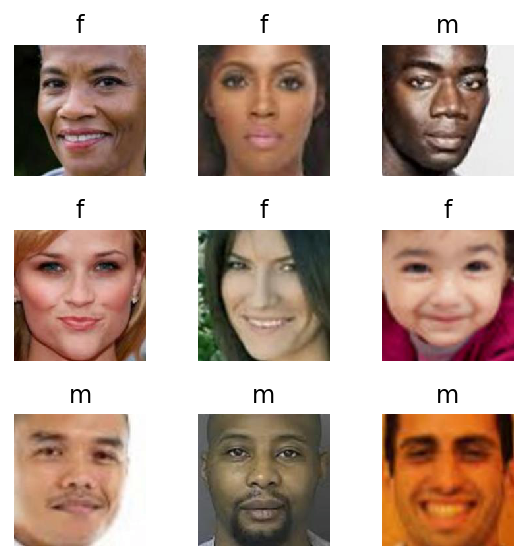

In [35]:
data.show_batch(rows=3, figsize=(4,4))

In [36]:
classes

['f', 'm']

The training and validation data sets are then combined to create a fastai `ImageDataBunch` object, which takes care of making images (`sz` being image size)and target variables into batches (`bs` being batch size), as well as transformations for image augmentation (from `get_transforms()`) and normalization (by `normalize(imagenet_stats)`) by imagenet mean and standard deviation. 


We can take a look at a random image and lable from the dataset. 

In one line of code, `create_cnn` function will create a `ClassificationLearner` object from the data and the pretrained model, here we use `resnet50`. 

In [37]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

In [38]:
type(learn)

fastai.basic_train.Learner

The library will determine the proper loss function (in this case `cross_entropy`) based on the data.

In [39]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

The output is 2-dimension (`out_features=2`), corresponding to the two classes 'f' and 'm'.

In [40]:
list(learn.model.children())[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=True)
)

We now use fastai learning rate finder to find the proper learning rate, a technique presented in Leslie Smith's paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186).

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


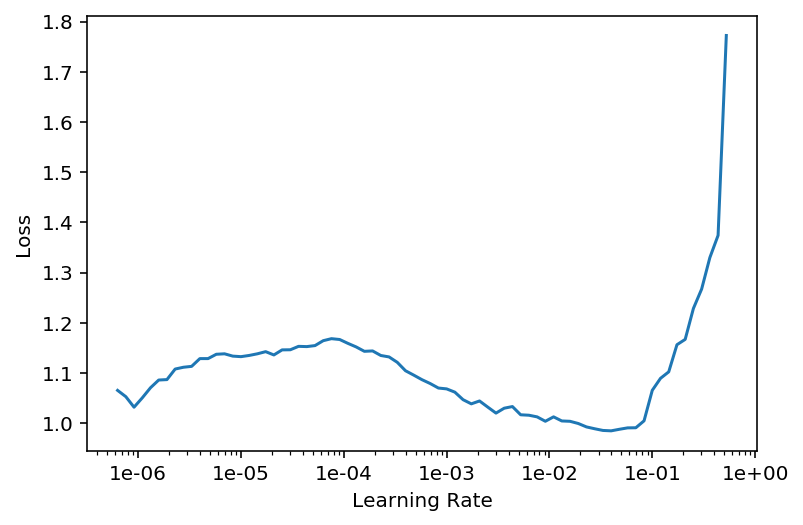

In [41]:
learn.lr_find()
learn.recorder.plot()

We select a learning rate a couple of magnitudes smaller than the one corresponding to the turning point of the loss function.

In [42]:
lr=1e-3

We can now take advantage of 1cycle training, an advanced learning strategy created in Leslie Smith's [paper](https://arxiv.org/abs/1803.09820), using fastai `fit_one_cycle` function. A good article that introduces this topic is [here](https://sgugger.github.io/the-1cycle-policy.html).


We first `freeze` the model to train the last linear layer and then `unfreeze` the bottom layers to fine tune the model.


In [43]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.504589,0.404765,0.180274,04:26
1,0.401368,0.363882,0.163697,07:01


We see a validation accuracy of 94%. 

In [44]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(lr/20, lr/2), pct_start=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,0.237783,0.212216,0.085993,02:19
1,0.108983,0.205097,0.073767,02:01


In [45]:
learn.save(f"{target}")

### race model 

Now on to the model for race. This is the only line different from the gender model.

In [46]:
target = 'race'

In [47]:
df = pd.read_csv('img2targets.csv', usecols=['img_name', target, 'is_valid'])

classes = sorted(set(df[target]))

In [48]:
classes

['Asian', 'Black', 'Indian', 'Others', 'White']

In [49]:
data = (ImageList.from_df(df, pdata)
        .split_from_df()
        .label_from_df(cols='race')
        .transform(tfms=[], size=200)
        .databunch())

data = data.normalize(imagenet_stats);

In [50]:
data

ImageDataBunch;

Train: LabelList (18879 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: CategoryList
White,White,White,White,White
Path: F:\Multi-task Deep Learning Experiment using fastai Pytorch\data\UTKFace;

Valid: LabelList (4826 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: CategoryList
White,White,Asian,White,White
Path: F:\Multi-task Deep Learning Experiment using fastai Pytorch\data\UTKFace;

Test: None

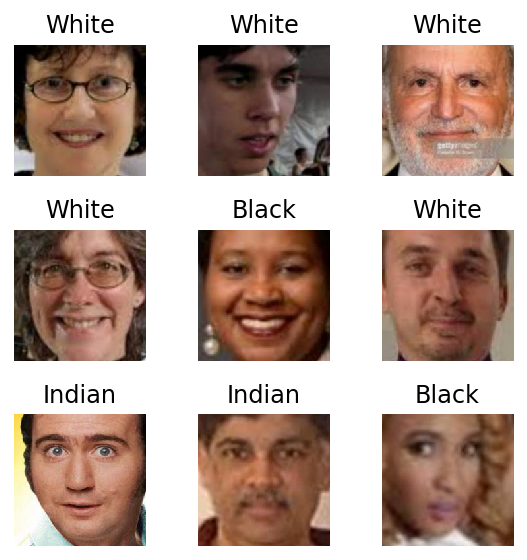

In [51]:
data.show_batch(rows=3, figsize=(4,4))

In [52]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

Notice now the output is 5-dimension (`out_features=5`) corresponding to the 5 races.

In [53]:
list(learn.model.children())[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=5, bias=True)
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


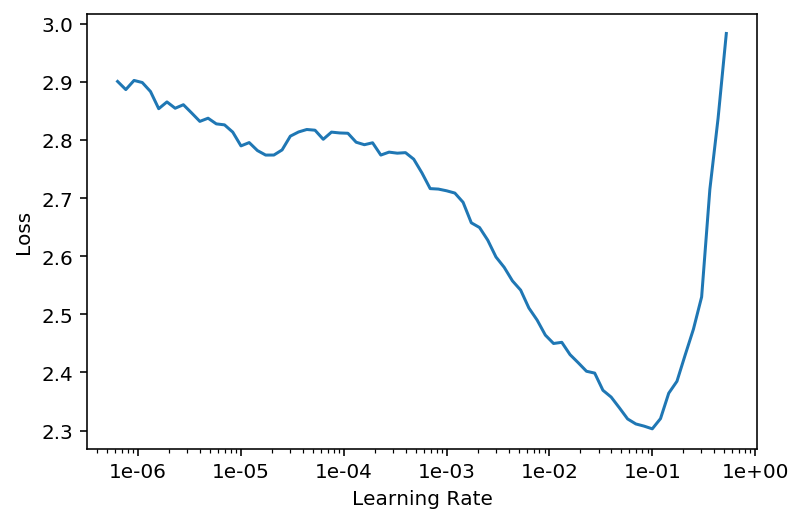

In [54]:
learn.lr_find()
learn.recorder.plot()

In [55]:
lr=1e-3

We see a validation accuracy of 86%. 

In [56]:
learn.fit_one_cycle(2, slice(lr))
learn.unfreeze()
learn.fit_one_cycle(2, slice(lr/20, lr/2), pct_start=0.1)
learn.save(f"{target}")

epoch,train_loss,valid_loss,error_rate,time
0,1.348081,0.980283,0.362412,01:38
1,1.041083,0.909124,0.340655,01:37


epoch,train_loss,valid_loss,error_rate,time
0,0.691790,0.572824,0.197472,02:02
1,0.386926,0.499336,0.163282,02:07


### age model

In [57]:
target = 'age'

df = pd.read_csv('img2targets.csv', usecols=['img_name', target, 'is_valid'])

The age prediction task is a regression problem. As the writing of this notebook, fastai does yet not have an `ImageRegressionDataset` class. (It's a fast growing library and might have one soon). So we will adapt `ImageClassificationDataset` a little bit into a regression dataset, by
1. setting `y` to be the value of the target variable (after adding a batch dimension by `[:, None]`;
2. setting `c=1`, so that the output of the network will be 1-dimension; and
3. setting `loss_func = F.l1_loss` for the regression problem.

As we can see it's not hard to change how the library currently works to adapt to your problem.

In [58]:
data = (ImageList.from_df(df, pdata)
        .split_from_df()
        .label_from_df(cols='age', label_cls = FloatList)
        .transform(tfms=[], size=200)
        .databunch())                          
data = data.normalize(imagenet_stats);

In [59]:
data

ImageDataBunch;

Train: LabelList (18879 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: FloatList
100.0,100.0,100.0,100.0,100.0
Path: F:\Multi-task Deep Learning Experiment using fastai Pytorch\data\UTKFace;

Valid: LabelList (4826 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: FloatList
100.0,100.0,101.0,105.0,10.0
Path: F:\Multi-task Deep Learning Experiment using fastai Pytorch\data\UTKFace;

Test: None

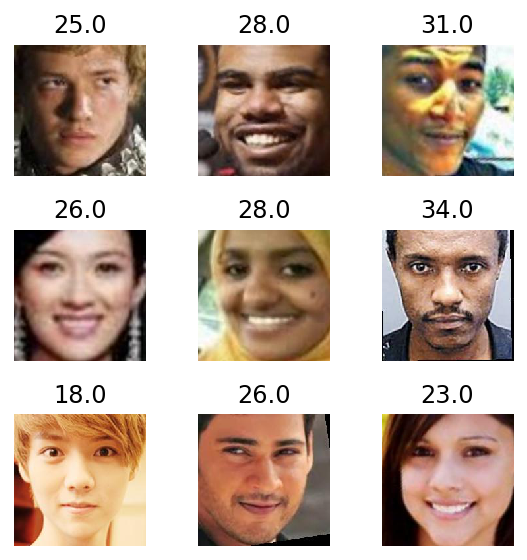

In [60]:
data.show_batch(rows=3, figsize=(4,4))

In [61]:
learn = cnn_learner(data, models.resnet18, metrics=mean_absolute_error)
learn.loss = MSELossFlat

Notice now the output is 1-dimension (`out_features=1`).

In [62]:
list(learn.model.children())[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=1, bias=True)
)

We can verify the loss function

In [63]:
learn.loss_func

FlattenedLoss of MSELoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


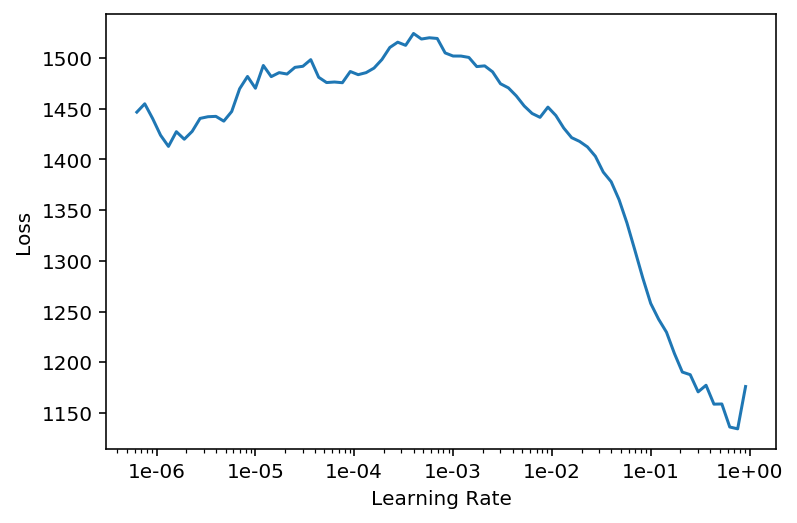

In [64]:
learn.lr_find()
learn.recorder.plot()

In [65]:
lr=1e-2

This gives us a 10-year average prediction error.

In [66]:
learn.fit_one_cycle(2, slice(lr))
learn.unfreeze()
learn.fit_one_cycle(2, slice(lr/20, lr/2), pct_start=0.1)
learn.save(f"{target}")

epoch,train_loss,valid_loss,mean_absolute_error,time
0,153.141861,111.013443,7.970127,01:40
1,109.794693,96.888039,7.223905,01:43


epoch,train_loss,valid_loss,mean_absolute_error,time
0,89.460365,66.838387,5.946386,02:13
1,57.913910,49.446907,5.096697,02:13


This concludes the single-task models. We now combine the three problems together to make a multi-task model.

## Multi-task model

### dataset

We will create a custom dataset called `MultitaskDataset` as a subclass of pytorch's (not fastai) `Dataset`. The goal is for it to be compatible with fastai `ImageDataBunch` so we can continue to take advantage of fastai library's other methods.

In [67]:
Dataset

torch.utils.data.dataset.Dataset

It draws inspiration from fastai `ImageClassificationDataset`.

In [68]:
df = pd.read_csv('img2targets2.csv')

class MultitaskDataset(Dataset):
    "`Dataset` for joint single and multi-label image classification."
    def __init__(self, 
                 fns,
                 labels_gender,
                 labels_race,
                 ages,
                 classes_race,
                 classes_gender):
        self.x = np.array(fns)
        
        self.classes_gender = classes_gender
        self.classes_race = classes_race

        self.class2idx_gender = {v:k for k,v in enumerate(self.classes_gender)}
        self.y_gender = np.array([self.class2idx_gender[o] for o in labels_gender], dtype=np.int64)

        self.class2idx_race = {v:k for k,v in enumerate(self.classes_race)}
        self.y_race = np.array([self.class2idx_race[o] for o in labels_race], dtype=np.int64)
        
        self.y_age = ages[:, None].astype('float32')
        
        self.c_gender = len(classes_gender)
        self.c_race = len(classes_race)
        self.c_age = 1

        self.c = self.c_gender + self.c_race + self.c_age

    
    def __len__(self): return len(self.x)
    
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray, np.ndarray]: 
        return open_image(self.x[i]), torch.tensor([self.y_gender[i], self.y_race[i], self.y_age[i]]).float()
    
    def __repr__(self): return f'{type(self).__name__} of len {len(self)}'

In [69]:
def get_dataset(df):
    return MultitaskDataset(df.img_name, 
                            labels_gender=df.gender, 
                            labels_race=df.race,
                            ages=df.age,
                            classes_race=sorted(set(df.race)),
                            classes_gender=sorted(set(df.gender))
                           )

In [70]:
train_ds = get_dataset(df[df.is_valid==0])
valid_ds = get_dataset(df[df.is_valid==1])

`x` component of the dataset if simply the image name.

In [71]:
valid_ds.x[:3]

array(['F:\\Multi-task Deep Learning Experiment using fastai Pytorch\\data\\UTKFace\\100_1_0_20170112213001988.jpg.chip.jpg',
       'F:\\Multi-task Deep Learning Experiment using fastai Pytorch\\data\\UTKFace\\100_1_0_20170117195420803.jpg.chip.jpg',
       'F:\\Multi-task Deep Learning Experiment using fastai Pytorch\\data\\UTKFace\\101_1_2_20170105174739309.jpg.chip.jpg'],
      dtype=object)

Target variables need more work. 
For the classification variables gender and race we define their classes (e.g. `classes_gender`) and class2idx lookup maps (e.g., `class2idx_gender`)

In [72]:
valid_ds.classes_gender

['f', 'm']

In [73]:
valid_ds.class2idx_gender

{'f': 0, 'm': 1}

We then tell the dataset what gender or race each image has

In [74]:
valid_ds.y_gender[:3]

array([0, 0, 0], dtype=int64)

age is simple, just a number for each image

In [75]:
valid_ds.y_age[:3]

array([[100.],
       [100.],
       [101.]], dtype=float32)

We need to set the cardinalities of the variables `c_gender`, `c_race`, `c_age`, and their sum `c`, so that we can create model of the right output dimension. 

In [76]:
valid_ds.c_gender, valid_ds.c_race, valid_ds.c_age, valid_ds.c

(2, 5, 1, 8)

Finally we need to set create the `__len__` and `__getitem__` methods which every pytorch `Dataset` must have. 

`__len__` simply returns the number of images in the dataset

In [77]:
len(valid_ds)

4826

In [88]:
fns[:3]

[WindowsPath('F:/Multi-task Deep Learning Experiment using fastai Pytorch/data/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg'),
 WindowsPath('F:/Multi-task Deep Learning Experiment using fastai Pytorch/data/UTKFace/100_0_0_20170112215240346.jpg.chip.jpg'),
 WindowsPath('F:/Multi-task Deep Learning Experiment using fastai Pytorch/data/UTKFace/100_1_0_20170110183726390.jpg.chip.jpg')]

`__getitem__` returns a tuple. The first is the image tensor, the second is the three target varialbes.

In [79]:
valid_ds[0][0].shape, valid_ds[0][1]

(torch.Size([3, 200, 200]), tensor([  0.,   4., 100.]))

In [80]:
def get_data(sz, bs):
    return ImageDataBunch.create(train_ds, valid_ds, path=p, bs=bs).normalize(imagenet_stats)

In [81]:
data = get_data(sz=200, bs=8)

In [82]:
data

ImageDataBunch;

Train: MultitaskDataset of len 18879;

Valid: MultitaskDataset of len 4826;

Test: None

Again, sanity check by looking at random pictures and labels.

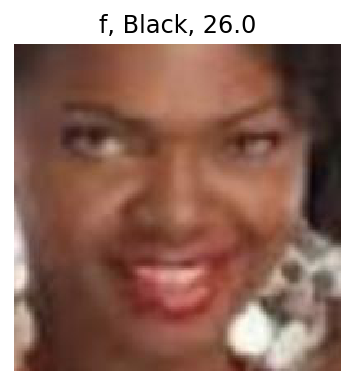

In [83]:
img, (igender, irace, age) = data.valid_ds[np.random.choice(len(data.valid_ds))]
gender = data.valid_ds.classes_gender[int(igender)]
race = data.valid_ds.classes_race[int(irace)]
img.show(title= f"{gender}, {race}, {age}")

### model

Now to the model. We will need to combine the three loss functions into one. For this we create this `multitask_loss` function below.
It uses `c_gender`, `c_race`, `c_age` of the dataset object to locate the model outputs corresponding to the three tasks:

```
input_gender = input[:,:data.c_gender]
input_race = input[:,data.c_gender:data.c_gender+data.c_race]
input_age = input[:,-data.c_age:]
```

It then get the target variables (the ground truth):
```
target_gender, target_race, target_age = target[:,0], target[:, 1], target[:, 2]
```

and feed them to the proper loss functions (`cross_entropy` for classification and `l1_loss` for regression)
```
loss_gender = F.cross_entropy(input_gender, target_gender.long())
loss_race = F.cross_entropy(input_race, target_race.long())
loss_age = F.l1_loss(input_age, target_age.unsqueeze(1))

```

Finally, we scale the losses so that they are of similar magnitude. The scaling factors can be observed from the single-task model above. For example, age prediction loss was about 10.
```
return loss_gender/(.16) + loss_race/(.44) +  loss_age/10
```

In [84]:
def multitask_loss(input, target):
    input_gender = input[:,:data.c_gender]
    input_race = input[:,data.c_gender:data.c_gender+data.c_race]
    input_age = input[:,-data.c_age:]
    target_gender, target_race, target_age = target[:,0], target[:, 1], target[:, 2]
    loss_gender = F.cross_entropy(input_gender, target_gender.long())
    loss_race = F.cross_entropy(input_race, target_race.long())
    loss_age = F.l1_loss(input_age, target_age.unsqueeze(1))
    return loss_gender/(.16) + loss_race/(.44) +  loss_age/10

For metrics, we again use `c_gender`, `c_race`, `c_age` of the dataset object to locate the model outputs corresponding to the three tasks and compute accuracy and l1_loss again the ground truth target.

In [85]:
def accuracy_gender(input, targs):
    input_gender = input[:,:data.c_gender]
    target_gender = targs[:, 0].long()
    return accuracy(input_gender, target_gender)

def accuracy_race(input, targs):
    input_race = input[:,data.c_gender:data.c_gender+data.c_race]
    target_race = targs[:, 1].long()
    return accuracy(input_race, target_race)

def l1loss_age(input, targs):
    input_age = input[:,-data.c_age:]
    target_age = targs[:, 2].unsqueeze(1)
    return F.l1_loss(input_age, target_age).mean()

Now we simple pass the custom data, pretrained model, custom metrics and custom loss functions to `create_cnn` to get our model.

In [86]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy_gender, accuracy_race, l1loss_age])
learn.loss = multitask_loss

In [87]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
lr=1e-3

In [ ]:
def train_model(sz, bs, lr):
    learn.data=get_data(sz, bs)
    learn.freeze()
    learn.fit_one_cycle(2, slice(lr))
    learn.unfreeze()
    learn.fit_one_cycle(2, slice(lr/20, lr/2), pct_start=0.1)
    learn.save(f"{target}")

We can see that the multi-task model cut average age prediction error in half from 10 years to 5 years while holding the gender and race prediction accuracy almost the same.

In [ ]:
train_model(200, 64, lr)

Also, we run the multi-task model once instead of three time for the single-task models (all four models have similar run time).

## Inspect results of the multi-task model

Now let's look at the result on validation set to make sure things work.

In [ ]:
preds = learn.get_preds()

In [ ]:
df_val = df[df.is_train==0]

nr, nc = 3, 3
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(5*nc, 4*nr))

inds_sample = np.random.choice(len(df_val), nr*nc, replace=False) 
for j, ind in enumerate(inds_sample):
    fn, age, gender, race, _ = df_val.iloc[ind].values

    o_gender, o_race, p_age = preds[1][ind].numpy().astype(int)
    p_gender=data.classes_gender[np.argmax(preds[0][ind][:data.c_gender])]
    p_race=data.classes_race[np.argmax(preds[0][ind][data.c_gender:data.c_gender+data.c_race])]
    p_age = max(0, preds[0][ind][-1])
    show_image(open_image(fn), axs[j//nc, j%nc])
    axs[j//nc, j%nc].set(title=f'age: {age} | pred:{p_age:.3} \n {gender} | pred:{p_gender}; {race} | pred:{p_race}')

Seems fine.

We can also take a look at the true v.s. predicted age.

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(df_val.age, preds[0][:,-1], alpha=.1)
plt.xlabel('true age')
plt.ylabel('predicted age')
plt.title('True v.s. Predicted Age')
plt.grid()

## Closing comments

In this notebook we showed:
1. an example of a multi-task deep learning model: predicting gender, race (both classification tasks), and age (a regression task), respectively, based on the face image;
2. that the multi-task model makes better predictions than the individual model; and
2. how to use the fastai library to implement the model.

Hopefully this convinces you to 
1. try building a multi-task model when related labels are available (it is very common in real life data) 
2. try using fastai library for it as it is easy and provides best practices out of the box.

We haven't considered a lot of things.
1. We've only scratched the surface of multi-task learning. There are a large variety of techniques to learn and experiment. Wikipedia and Sebastian Ruder's [article](http://ruder.io/multi-task/) are good reference.
2. We kept the model building part simple on purpose to focus on the multi-task part. We didn't experiment with model architecture including the pretrained backbone and the top layers, we didn't tune dropout, and we didn't consider progressively increasing image size for training, a effective technique taught by fastai. In a real world application these are worth considering and testing, and fastai library usually makes it easy.